In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
N_CONCEPTS = 2
N_STUDENTS = 10
N_ATTEMPTS = 3
N_QUESTIONS = 5

# Algorithm parameters
INIT = 3
MAX_ITER = 100

### FDTF Tensor Factorization

In [3]:
def feedback_driven_tensor_factorization(student_performance, n_concepts=2, mu=1, init=3, max_iter=100):
    """ Student performance: 0 if incorrect, 1 if correct or None if not observed """
    
    # Get values from student performance tensor shape
    n_students, n_questions, n_attempts = student_performance.shape
    
    # Construct tensor X denoting when a student has or has not chosen to work on a problem
    X = np.ones(student_performance.shape)
    X[np.where(np.isnan(student_performance))] = 0
    # Complete student knowledge tensor with zero where is NaN
    student_performance[np.where(np.isnan(student_performance))] = 0
    
    # Create student knowledge tensor
    student_knowledge = np.zeros((n_students, n_concepts, n_attempts))

    error_run = []
    error_total_run = []
    student_performance_pred_run = []
    
    # Several starts
    for run in range(init):
        error = []
        student_performance_pred_list = []

        for attempt in range(N_ATTEMPTS):
            student_knowledge[:, :, attempt] = np.random.rand(n_students, n_concepts)

        student_performance_pred = np.zeros(student_performance.shape)
        for i in range(max_iter):
            # Phase 1: prediction
            # Update Q: Q = (T'T)^(-1)T'Y = T^(-1)Y
            # (T'T)^(-1)
            student_knowledge_transposed = np.zeros((n_concepts, n_concepts, n_attempts))
            for attempt in range(n_attempts):
                student_knowledge_transposed[:, :, attempt] = np.dot(student_knowledge[:, :, attempt].T, 
                                                                     student_knowledge[:, :, attempt])
            student_knowledge_transposed = student_knowledge_transposed.sum(axis=2)
            student_knowledge_transposed_inv = np.linalg.pinv(student_knowledge_transposed)
            
            # T'Y
            TY = np.zeros((n_concepts, n_questions, n_attempts))
            for attempt in range(n_attempts):
                TY[:, :, attempt] = np.dot(student_knowledge[:, :, attempt].T, 
                                           student_performance[:, :, attempt])
            TY = TY.sum(axis=2)
            
            ## TODO: add regularization parameters (lambda)
            # Q = (T'T)^(-1)T'Y
            q_matrix = np.dot(student_knowledge_transposed_inv, TY)
            # Impose non-negativity constraint
            q_matrix[q_matrix < 0] = 0
            # Normalize rows to sum one
            row_sums = q_matrix.sum(axis=0, keepdims=True)
            q_matrix = q_matrix / row_sums
            
            # Phase 2: learning
            # Update T: T = 2*(T_{t-1}) + 2*((1-T_{t-1})/(1+exp(-mu*X_{t}*Q'))) - 1
            # For T0 user T-1 as 0
            student_knowledge[:, :, 0] = 2/(1+np.exp(-mu*np.dot(X[:,:,0], q_matrix.T)))
            for attempt in range(n_attempts):
                student_knowledge[:, :, attempt] = (2*student_knowledge[:, :, attempt-1]) + \
                2*(1-student_knowledge[:, :, attempt-1])/(1+np.exp(-mu*np.dot(X[:,:,attempt], q_matrix.T))) - 1
                
            # Y = TQ
            for attempt in range(n_attempts):
                student_performance_pred[:, :, attempt] = np.dot(student_knowledge[:, :, attempt], q_matrix)
                
            
            diff = np.zeros((n_students, n_questions, n_attempts))
            for attempt in range(n_attempts):
                diff[:, :, attempt] = student_performance[:, :, attempt] - student_performance_pred[:, :, attempt]
            # Frobenius norm (norm-2)
            error.append(np.sqrt(np.sum(np.power(diff, 2))))
            
            student_performance_pred_iter = student_performance_pred.copy()
            student_performance_pred_list.append(student_performance_pred_iter)
        student_performance_pred_run.append(student_performance_pred_list)
        error_run.append(error)
        error_total_run.append(error[-1])
                
    return np.asarray(student_performance_pred_run), np.asarray(error_run), error_total_run

### Simulation 1 - Student Performance is the exact multiplication of  Q Matrix and Student Knowledge

In [6]:
def generate_sample(noise=0):
    DENSITY = 0.8

    # Create sparse q_matrix and normalize it to sum 1
    q_matrix = sparse.rand(N_CONCEPTS, N_QUESTIONS, DENSITY).todense()
    row_sums = q_matrix.sum(axis=0)
    while not(np.all(row_sums)):
        q_matrix = sparse.rand(N_CONCEPTS, N_QUESTIONS, DENSITY).todense()
        row_sums = q_matrix.sum(axis=0)
    q_matrix = q_matrix / row_sums

    student_knowledge = np.zeros((N_STUDENTS, N_CONCEPTS, N_ATTEMPTS))
    for attempt in range(N_ATTEMPTS):
        student_knowledge[:, :, attempt] = sparse.rand(N_STUDENTS, N_CONCEPTS, DENSITY).todense()

    student_performance = np.zeros((N_STUDENTS, N_QUESTIONS, N_ATTEMPTS))
    for attempt in range(N_ATTEMPTS):
        student_performance[:, :, attempt] = np.dot(student_knowledge[:, :, attempt], q_matrix)
        
    if noise:
        noise = np.random.normal(0, noise, (N_STUDENTS, N_QUESTIONS, N_ATTEMPTS))
        student_performance = student_performance + noise
        
    return student_performance

In [7]:
student_performance = generate_sample()

In [8]:
student_performance_pred_run, error_run, error_total_run = feedback_driven_tensor_factorization(
    student_performance, n_concepts=2, init=1, max_iter=4)

In [9]:
error_run

array([[7.77602461, 8.12932797, 8.13013743, 8.13013743]])

### Simulation 2 - Student Performance is the multiplication of Q Matrix and Student Knowledge plus noise

In [12]:
student_performance_pred_run, error_run, error_total_run = feedback_driven_tensor_factorization(
    student_performance, n_concepts=2, init=3, max_iter=5)

In [13]:
error_run

array([[10.71384301, 10.93622723, 10.93728775, 10.93729026, 10.93729026],
       [10.68083926, 10.92919072, 10.93692399, 10.93728529, 10.93729019],
       [10.61797541, 10.92099033, 10.93725507, 10.93729023, 10.93729026]])

### Simulation 3 - Student Performance contains only zeros and ones

In [14]:
student_performance = generate_sample(0.5)

In [15]:
student_performance[student_performance > 0.5] = 1
student_performance[student_performance < 0.5] = 0

In [18]:
# Add random None
total = np.prod(student_performance.shape)
random_questions = np.random.randint(0, N_QUESTIONS, int(0.2*total))
random_students = np.random.randint(0, N_QUESTIONS, int(0.2*total))
random_attempts = np.random.randint(0, N_ATTEMPTS, int(0.2*total))

student_performance[random_questions, random_students, random_attempts] = None

In [19]:
student_performance_pred_run, error_run, error_total_run = feedback_driven_tensor_factorization(
    student_performance, n_concepts=2, init=3, max_iter=100)

In [20]:
error_run = np.asarray(error_run)

In [21]:
best_run = np.unravel_index(error_run.argmin(), error_run.shape)
best_student_performance_pred = student_performance_pred_run[best_run]

In [22]:
best_student_performance_pred[best_student_performance_pred > 0.5] = 1
best_student_performance_pred[best_student_performance_pred < 0.5] = 0

In [23]:
acc = 100*(np.logical_not(np.logical_xor(
    student_performance, best_student_performance_pred)).sum())/(
    student_performance.shape[0]*student_performance.shape[1]*student_performance.shape[2])
print("Accuracy: %.2f%%" % acc)

Accuracy: 40.67%


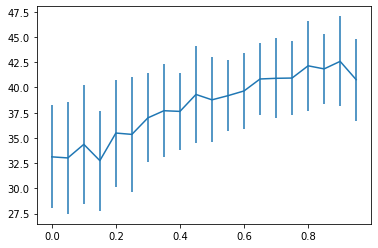

CPU times: user 1min 5s, sys: 19.2 ms, total: 1min 5s
Wall time: 1min 5s


In [211]:
%%time
accs = []
accs_std = []

for noise in np.arange(0, 1, 0.05):
    accs_run = []
    for run in range(50):
        # Generate sample and approximate values to 0 and 1
        student_performance = generate_sample(noise)
        student_performance[student_performance > 0.5] = 1
        student_performance[student_performance < 0.5] = 0
        
        # Add random None
        random_questions = np.random.randint(0, N_QUESTIONS, int(0.1*total))
        random_students = np.random.randint(0, N_QUESTIONS, int(0.1*total))
        random_attempts = np.random.randint(0, N_ATTEMPTS, int(0.1*total))

        student_performance[random_questions, random_students, random_attempts] = None
        

#         Run tensor factorization
        student_performance_pred_run, error_run, error_total_run = feedback_driven_tensor_factorization(
            student_performance, n_concepts=2, init=3, max_iter=50)
        

#         Get best run results
        best_run = np.unravel_index(error_run.argmin(), error_run.shape)
        best_student_performance_pred = student_performance_pred_run[best_run]
        best_student_performance_pred[best_student_performance_pred > 0.5] = 1
        best_student_performance_pred[best_student_performance_pred < 0.5] = 0
        

#         Calculate accuracy
        acc = 100*(np.logical_not(np.logical_xor(
            student_performance, best_student_performance_pred)).sum())/(
            student_performance.shape[0]*student_performance.shape[1]*student_performance.shape[2])
        accs_run.append(acc)

    accs.append(np.asarray(accs_run).mean())
    accs_std.append(np.asarray(accs_run).std())
    
plt.errorbar(np.arange(0, 1, 0.05), accs, yerr=accs_std)
plt.show()

In [485]:
diff = np.zeros((N_QUESTIONS, N_STUDENTS, N_ATTEMPTS))
for attempt in range(N_ATTEMPTS):
    diff[:, :, attempt] = student_performance[:, :, attempt] - best_student_performance_pred[:, :, attempt]

In [486]:
np.sqrt(np.sum(np.power(diff, 2)))

4.898979485566356